(100, 5, 2)
(100, 2, 6)
(100, 1)


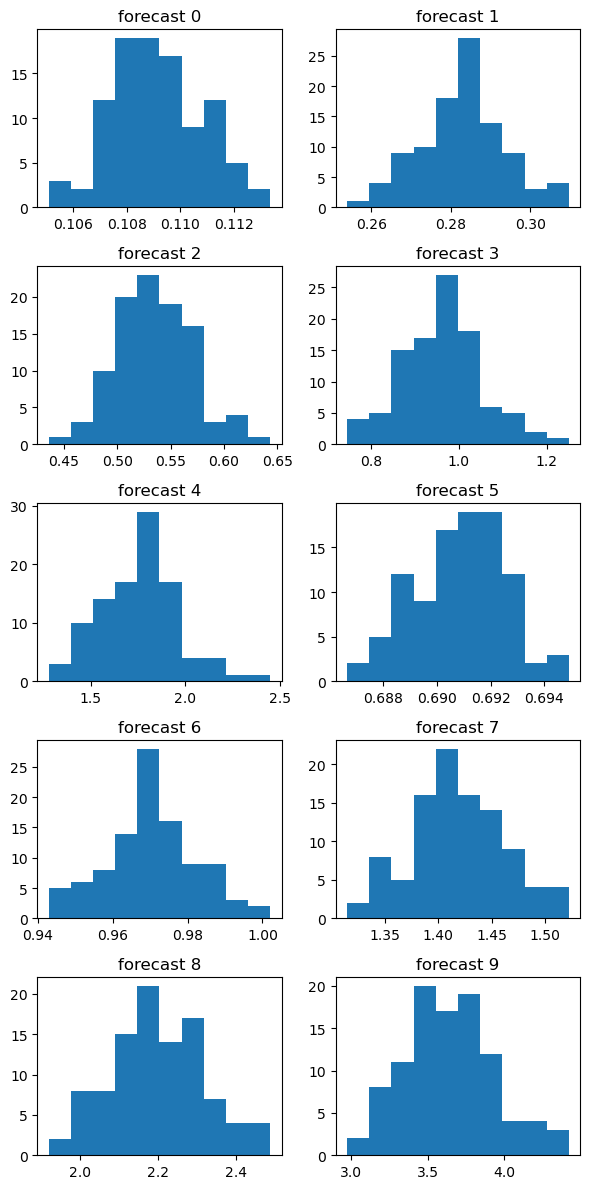

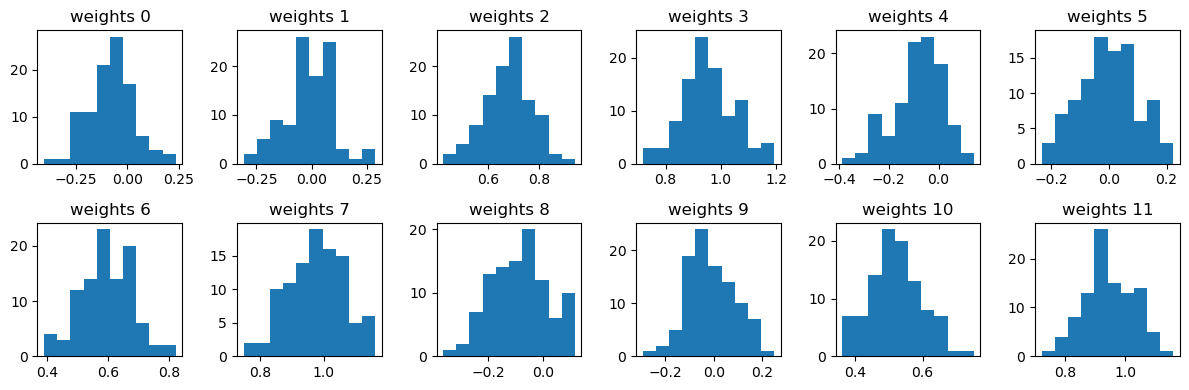

IndexError: tuple index out of range

In [78]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

forecast = np.load('forecast.npy')
weights = np.load('weights.npy')
biases = np.load('biases.npy')

print(forecast.shape)
print(weights.shape)
print(biases.shape)


variable = forecast
fig, axs = plt.subplots(5, 2, figsize=(6, 12))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Plot histograms in each subplot
for z in range(variable.shape[2]):
    for y in range(variable.shape[1]):
        f_list = []
        for x in range(variable.shape[0]):
            f_list.append(variable[x][y][z])
        axs[z*variable.shape[1]+y].hist(f_list, bins=10)
        axs[z*variable.shape[1]+y].set_title(f'forecast {z*variable.shape[1]+y}')
f_list = []

plt.tight_layout()
plt.show()

variable = weights
fig, axs = plt.subplots(variable.shape[1], variable.shape[2], figsize=(12, 4))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Plot histograms in each subplot
for z in range(variable.shape[2]):
    for y in range(variable.shape[1]):
        f_list = []
        for x in range(variable.shape[0]):
            f_list.append(variable[x][y][z])
        axs[z*variable.shape[1]+y].hist(f_list, bins=10)
        axs[z*variable.shape[1]+y].set_title(f'weights {z*variable.shape[1]+y}')
f_list = []

plt.tight_layout()
plt.show()
